# EJC Demo

This demonstrates some basic summary statistics and SVD-based topic modeling on the EJC data from Assignment 5.

## Setup

In [9]:
library(MASS)
library(tidyverse)
library(modelr)
library(tidytext)
library(SnowballC)

Set up database table access.

In [41]:
db = src_sqlite('data/ejc-trimmed.db')
journals = tbl(db, 'journals')
articles = tbl(db, 'articles')

Build some quick summary stats on the data.

In [42]:
journals %>%
    inner_join(articles) %>%
    group_by(name) %>%
    summarize(ArticleCount=n(), FirstYear=min(year), LastYear=max(year)) %>%
    collect()

Joining, by = "jnl_id"


name,ArticleCount,FirstYear,LastYear
AdvPeace,8991,1834,1922
AmPhil,755,1769,1920
AmRev,14770,1815,1922
RoyalPhil,8128,1665,1869
Science,36878,1880,1922


## Work with Royal Philosophical Transactions

First, let's grab all RoyalPhil articles from 1776, so we have a reasonable number of articles for a quick demo.

In [6]:
art_sample = journals %>% inner_join(articles) %>%
    filter(name == 'RoyalPhil', year == 1776) %>%
    select(article_id, title, text) %>%
    collect()
dim(art_sample)

Joining, by = "jnl_id"


[1] 46  3

Tokenize the article text:

In [15]:
art_words = art_sample %>% select(-title) %>%
    unnest_tokens(word, text) %>%
    group_by(article_id) %>% mutate(pos=1:n()) %>%
    ungroup()
head(art_words)

article_id,word,pos
12422,the,1
12422,royal,2
12422,society,3
12422,of,4
12422,london,5
12422,philosophical,6


Strip stop words and stem:

In [16]:
art_stems = art_words %>%
    anti_join(stop_words) %>%
    mutate(stem = wordStem(word))
head(art_stems)

Joining, by = "word"


article_id,word,pos,stem
12439,"0,075",7805,"0,075"
12440,"0,075",1603,"0,075"
12438,hantum,12067,hantum
12429,populo,7399,populo
12429,populo,7883,populo
12423,shell,1293,shell


In [17]:
art_stems %>% filter(word != stem) %>% head()

article_id,word,pos,stem
12429,honours,1738,honour
12429,honours,2741,honour
12505,harts,2615,hart
12422,inlarged,1603,inlarg
12434,depends,1338,depend
12434,depends,1543,depend


In [18]:
vocabulary = unique(art_stems$word)
vocab_stems = unique(art_stems$stem)

In [19]:
length(vocabulary)

[1] 11273

In [20]:
length(vocab_stems)

[1] 8819

Count frequencies of stemmed words.

In [22]:
stem_freq = art_stems %>%
    count(article_id, stem)
head(stem_freq)

article_id,stem,n
12422,1,1
12422,109,1
12422,129,1
12422,160,1
12422,168,1
12422,1719,1


Build a document-term matrix.

In [44]:
doc_stem_mat = stem_freq %>%
    cast_sparse(article_id, stem, n) %>%
    as.matrix()
doc_stem_mat

,1,109,129,160,168,1719,174,1752,1772,1773,...,twiss,vallanc,vase,vergist,vindex,vinuela,wallerii,welbeck,wolf,woulse'
12422,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
12423,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12424,420,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12425,47,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12426,1,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
12427,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12428,377,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12429,27,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12430,0,1,0,1,1,0,0,0,2,2,...,0,0,0,0,0,0,0,0,0,0
12431,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Decompose the matrix with SVD:

In [28]:
decomp = svd(doc_stem_mat, 10, 10)

In [30]:
dim(decomp$u)

[1] 46 10

In [31]:
dim(decomp$v)

[1] 8819   10

Make a nice topic-word data frame.

In [32]:
word_topics = as_data_frame(decomp$v) %>%
    mutate(term = colnames(doc_stem_mat))
head(word_topics)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,term
-5.514154e-01,-0.0291958750,0.045257859,-0.710858005,0.010795582,-0.020202552,-0.019108828,-0.047936723,-0.043868647,-0.1759635219,1
-1.679014e-04,-0.0004339127,0.007163719,-0.001064589,0.007685225,-0.003396180,0.003391719,-0.005465178,0.003666419,-0.0025776460,109
-1.592554e-04,-0.0007815958,0.015952645,0.002538242,0.017659707,-0.007797064,0.008845475,-0.008986529,0.003199684,-0.0064909069,129
-8.039237e-05,-0.0003700950,0.007343063,0.001128478,0.008422854,-0.003446524,0.004558911,-0.002950301,-0.000974906,-0.0026799535,160
-1.569148e-04,-0.0005005004,0.008709793,0.001927456,0.009373644,-0.004058271,0.004394282,-0.006032053,0.004699127,0.0001296609,168
-1.317022e-03,-0.0048915701,0.010728777,0.004034746,0.013064858,-0.005366085,0.006015598,-0.009159237,0.004781264,-0.0094421619,1719


What are the top 10 terms for topic 1?

In [34]:
word_topics %>% arrange(-V1) %>% select(term, V1) %>% head(10)

term,V1
achromat,-6.046602e-08
cassini,-6.046602e-08
dolland,-6.046602e-08
fainter,-6.046602e-08
jupit,-6.046602e-08
planet,-6.046602e-08
planet',-6.046602e-08
ballast,-4.479649e-07
eveningtid,-4.479649e-07
gale,-4.479649e-07


In [35]:
word_topics %>% arrange(-V2) %>% select(term, V2) %>% head(10)

term,V2
0,0.42637225
fine,0.21572177
fair,0.20031817
sw,0.08595739
rain,0.08451298
ssw,0.07288898
cloudi,0.07024208
7,0.05795443
wsw,0.04804981
ne,0.04408565


Let's look at documents.

In [36]:
doc_topics = as_data_frame(decomp$u) %>%
    mutate(article_id = as.integer(rownames(doc_stem_mat)))
head(doc_topics)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,article_id
-0.001817758,-0.005876418,0.06168811,0.004450154,0.028152789,-0.011502998,0.01790852,-0.019611439,0.0331153542,-0.003844549,12422
-0.006567550,-0.015919355,0.08533692,0.010287696,-0.053676543,-0.037901436,-0.02893029,0.001602841,-0.0168501901,0.092755125,12423
-0.493520150,-0.824199072,-0.13138797,0.162655701,-0.008521754,0.016442304,-0.01473966,-0.028300459,-0.0240237616,-0.153885729,12424
-0.027213688,-0.037334037,0.12132619,-0.097240018,0.196727491,-0.044473362,0.22395983,0.424221961,-0.7956374755,0.110469494,12425
-0.006728006,-0.014671627,0.03541532,0.015851445,-0.012395975,0.005870345,0.01533964,0.040878041,-0.0007146078,0.035999245,12426
-0.002256482,-0.007256592,0.04600736,0.013078563,-0.017723322,-0.042856022,-0.02795572,-0.008854953,0.0070596144,-0.011093817,12427


In [38]:
doc_topics %>% select(article_id, V1) %>%
    arrange(-V1) %>%
    head(10) %>%
    inner_join(art_sample) %>%
    select(article_id, V1, title) %>% arrange(-V1)

Joining, by = "article_id"


article_id,V1,title
12458,-9.806382e-05,"A Belt on the Disc of Saturn Described in an Extract of a Letter from Mr. Messier, F. R. S. to Mr. Magellan, F. R. S. Dated Paris, May 29, 1776"
12449,-7.265096e-04,"Of the Tides in the South Seas. By Captain James Cook, F. R. S."
12453,-7.555608e-04,"Of the Light Produced by Inflammation. By George Fordyce, M. D. F. R. S."
12456,-8.160561e-04,"Account of the Iron Ore Lately Found in Siberia. In a Letter to Dr. Maty, Sec. R. S. by Petr. Simon Pallas, M. D. F. R. S."
12461,-8.766023e-04,"An Account of a Suppression of Urine Cured by a Puncture Made in the Bladder through the Anus; Being an Extract of a Letter from Dr. Robert Hamilton, Fellow of the Royal College of Physicians at Edinburgh, and Physician at King's-Lynn, in Norfolk, to Sir John Pringle, Bart. P. R. S."
12444,-8.866600e-04,"The Method Taken for Preserving the Health of the Crew of His Majesty's Ship the Resolution during Her Late Voyage Round the World. By Captain James Cook, F. R. S. Addressed to Sir John Pringle, Bart. P. R. S."
12516,-9.384814e-04,Errata
12445,-9.680570e-04,"Extraordinary Electricity of the Atmosphere Observed at Islington on the Month of October, 1775. By Mr. Tiberius Cavallo. Communicated by William Watson, M. D. V. P. R. S."
12454,-9.728494e-04,"Experiments on Ignited Bodies. By John Roebuck, M. D. F. R. S."
12460,-1.271565e-03,"Experiments on Ignited Substances. By Mr. John Whitehurst, in a Letter to James Stuart, Esquire, F. R. S."


In [39]:
doc_topics %>% select(article_id, V2) %>%
    arrange(-V2) %>%
    head(10) %>%
    inner_join(art_sample) %>%
    select(article_id, V2, title) %>% arrange(-V2)

Joining, by = "article_id"


article_id,V2,title
12439,0.5365240766,"Meteorological Journal Kept at the House of The Royal Society, By Order of the President and Council"
12441,0.0019365759,"Extract of a Meteorological Journal for the Year 1775, Kept at Bristol, by Samuel Farr, M. D."
12494,0.0014573560,"A Demonstration of Two Theorems Mentioned in Art. XXV. of the Philosophical Transactions for the Year 1775. In a Letter from Charles Hutton, Esq. F. R. S. to the Rev. Dr. Horsley, Sec. R. S."
12458,-0.0004536025,"A Belt on the Disc of Saturn Described in an Extract of a Letter from Mr. Messier, F. R. S. to Mr. Magellan, F. R. S. Dated Paris, May 29, 1776"
12460,-0.0016946992,"Experiments on Ignited Substances. By Mr. John Whitehurst, in a Letter to James Stuart, Esquire, F. R. S."
12445,-0.0017995272,"Extraordinary Electricity of the Atmosphere Observed at Islington on the Month of October, 1775. By Mr. Tiberius Cavallo. Communicated by William Watson, M. D. V. P. R. S."
12453,-0.0018297868,"Of the Light Produced by Inflammation. By George Fordyce, M. D. F. R. S."
12444,-0.0019380252,"The Method Taken for Preserving the Health of the Crew of His Majesty's Ship the Resolution during Her Late Voyage Round the World. By Captain James Cook, F. R. S. Addressed to Sir John Pringle, Bart. P. R. S."
12516,-0.0020287234,Errata
12432,-0.0021990191,"An Account of the Success of Some Attempts to Freeze Quicksilver, at Albany Fort, in Hudson's Bay, in the Year 1775: With Observations on the Dipping-Needle. By Thomas Hutchins, Esquire, in a Letter to Dr. Maty, Sec. R. S."


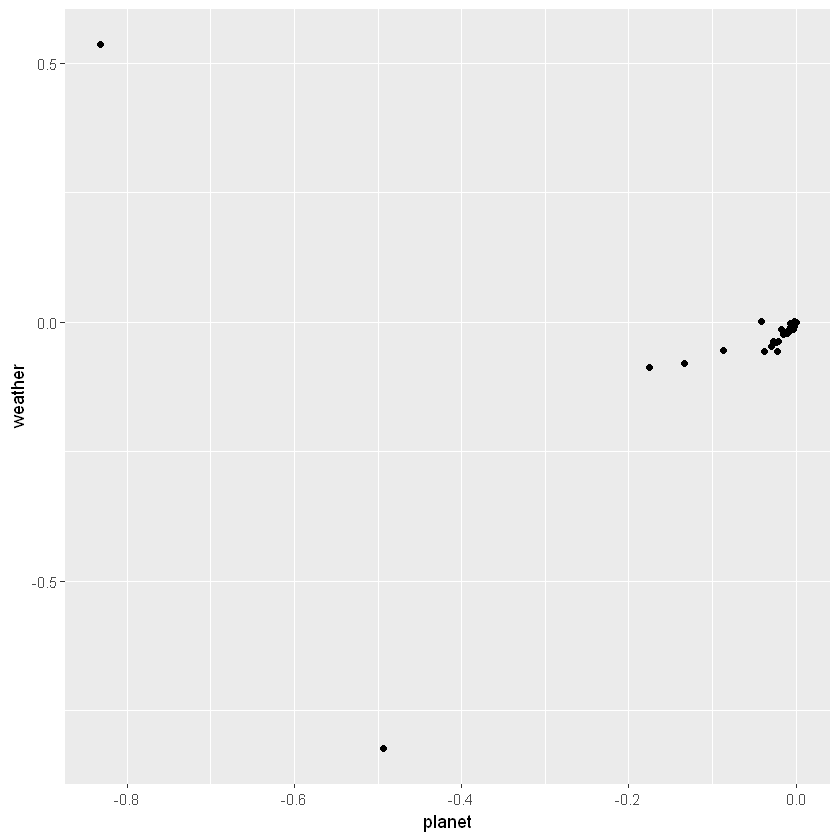

In [40]:
ggplot(doc_topics) +
    aes(x=V1, y=V2) +
    geom_point() +
    xlab("planet") +
    ylab("weather")